## GitHub Data Analysis


## Introduction
Every software engineer uses GitHub. Being a open source distributed version control tool, GitHub has thoundsands of new repositorys in every hour. Thus, GitHub could also be used as a huge dynamic data source to analyze technology status quo and trend.

In this project, we will be looking into serveral things like who is the most popular person in certain field, what is the current hottest project and how much does different programming languages being used.


### GitHub API

We will use GitHub API from [here](https://developer.github.com/v3/).
All the API calls are using HTTPS requests and it will return in JSON format.

Steps to use GitHub API:
1. Install `pygithub` by 
`-pip install pygithub`
2. Generate a GitHub Personal access token required for `GitHub API`
3. Test You API in local terminal using the following command. It is expected to return a list of dictionary contains your account info
##### - curl https://api.github.com/user\?access_token\={YOUR_TOKEN}




### NetworkX
NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It provides tools to work with large dataset with network strucutres. With NetworkX, we can load and store neyworks in standard data format easily. It can also helps us to generate classic networks, analyze network strucutre, build network models and much more.

You can install `NetworkX` by `-pip install networkx`


In [14]:
import sys
from github import Github
import networkx as nx
from operator import itemgetter

# Global Variables
ACCESS_TOKEN = '05bb4eb867b152be20dd11f4fa292107c839931c'
USER = 'minrk'  # Define the GitHub User Name
REPO = 'findspark'  # Define the Repo name
client = Github(ACCESS_TOKEN)
graph = nx.DiGraph()

### Set Up NetworkX Graph


After defined the user and repo name that we are going to explore, we can then set up the NetworkX graph.

We will add the repo and each user who starred the repo as nodes, and build edges between them. After this, we also add edges between users and their followers. 

In [19]:
def buildRepoRelations(REPO):
    user = client.get_user(USER)
    repo = user.get_repo(REPO)  # Get a specific repo
    REPOS = user.get_repos()
    stargazers = list(repo.get_stargazers())  # The list of users who starred this REPO
    graph.add_node(repo.name + '(repo)', type='repo', lang=repo.language, owner=user.login)
    for stargazer in stargazers:
        graph.add_node(stargazer.login + '(user)', type='user')
        graph.add_edge(stargazer.login + '(user)', repo.name + '(repo)', type='gazes')
    #	print(len(stargazers))#See if it return a correct list
    return stargazers


def buildUserRelations(stargazers):
    for i, stargazer in enumerate(stargazers):
        followers = stargazer.get_followers()
        try:
            for follower in followers:
                if follower.login + '(user)' in graph:
                    graph.add_edge(follower.login + '(user)', stargazer.login + '(user)', type='follows')
        except Exception:  
            print("Encountered an error when finding follower for user: ", stargazer.login)
        #See How many available API calls remaining
        print ("API Calls Remaining", client.rate_limiting)

In [20]:
stargazers = buildRepoRelations(REPO)
buildUserRelations(stargazers)

API Calls Remaining (4988, 5000)
API Calls Remaining (4963, 5000)
API Calls Remaining (4960, 5000)
API Calls Remaining (4958, 5000)
API Calls Remaining (4955, 5000)
API Calls Remaining (4937, 5000)
API Calls Remaining (4935, 5000)
API Calls Remaining (4934, 5000)
API Calls Remaining (4925, 5000)
API Calls Remaining (4922, 5000)
API Calls Remaining (4921, 5000)
API Calls Remaining (4916, 5000)
API Calls Remaining (4914, 5000)
API Calls Remaining (4913, 5000)
API Calls Remaining (4912, 5000)
API Calls Remaining (4911, 5000)
API Calls Remaining (4902, 5000)
API Calls Remaining (4901, 5000)
API Calls Remaining (4900, 5000)
API Calls Remaining (4898, 5000)
API Calls Remaining (4896, 5000)
API Calls Remaining (4894, 5000)
API Calls Remaining (4893, 5000)
API Calls Remaining (4892, 5000)
API Calls Remaining (4891, 5000)
API Calls Remaining (4890, 5000)
API Calls Remaining (4889, 5000)
API Calls Remaining (4886, 5000)
API Calls Remaining (4885, 5000)
API Calls Remaining (4884, 5000)
API Calls 

### Find Hottest User
In this step, we use the graph initialized above to find the hottest users. The hottest user is defined as the GitHub user followed by most of the people who starred the repo we defined previously. This can also be interpreted as those who starred this repo also follows ... 


In [103]:
from collections import Counter
from operator import itemgetter

def getHottestUser(stargazers):
    
    temp_list = []
    for edge in graph.edges(data = True):
        if edge[2]['type'] == 'follows':
            temp_list.append(edge[1])
    counter = Counter(temp_list)
    
    popular_users = []
    for u, f in counter.most_common():
        popular_users.append((u,f))
    print ("Number of popular users", len(popular_users))
    print ("Top popular users:", popular_users[:10])
    return popular_users[:10]
hottestUsers = getHottestUser(stargazers)




Number of popular users 27
Top popular users: [('stared(user)', 6), ('freeman-lab(user)', 5), ('rgbkrk(user)', 4), ('nchammas(user)', 3), ('dclambert(user)', 3), ('esafak(user)', 3), ('dapurv5(user)', 2), ('rholder(user)', 2), ('xiaohan2012(user)', 2), ('amontalenti(user)', 2)]


The result above shows the most popular users. However, we care more about some centralities that NetworkX provided.
#### Degree Centrality
First, the Degree Centrality for a node v is the fraction of nodes it is connected to. 
#### Betweenness Centrality
Also, the Betweenness Centrality compute the shortest path for nodes. It is the sum of the fraction of all-pairs shortest paths that pass through the node v. 
#### Closeness Centrality
Lastly, the Closeness Centrality of a node u is the reciprocal of the sum of the shortest path distances from u to all n-1 other nodes. Since the sum of distances depends on the number of nodes in the graph, closeness is normalized by the sum of minimum possible distances n-1.




In [7]:
def formatResult(graph):
    graph_copy = graph.copy()
    # Remove center node
    graph_copy.remove_node('findspark(repo)')

    dc = sorted(nx.degree_centrality(graph_copy).items(), 
                key=itemgetter(1), reverse=True)

    bc = sorted(nx.betweenness_centrality(graph_copy).items(), 
                key=itemgetter(1), reverse=True)
    cc = sorted(nx.closeness_centrality(graph_copy).items(), 
                key=itemgetter(1), reverse=True)
    return (dc, bc, cc)

dc, bc, cc = formatResult(graph)

print ("Degree Centrality")
print (dc[:5],'\n')

print ("Betweenness Centrality")
print (bc[:5],'\n')

print ("Closeness Centrality")
print (cc[:5])

### Find Hottest Repository 

For the network we have currently, there is only one repo. To find the hottest repository, we need to go through each user in the network and then add their starred repos into the network. After that, it is easy for us to get the popular repositories. Moreover, we can also get to know the language preference of one certain user.

There are two input parameters of function buildRepoNet. The stargazers is the output of function buildRepoRelations which is a list of users who starred this original repo. Sometimes a user marks too many repos and it takes a lot of time to build the net. So here the limit_repo parameter could define the maximum of the repos of one user we need to add into the net. 

In [25]:
def buildRepoNet(stargazers, limit_repo):
    for i, v in enumerate(stargazers):
        print(v.login)
        try:
            for starred in v.get_starred()[:limit_repo]:  # Slice to avoid supernodes
                graph.add_node(starred.name + '(repo)', type='repo', lang=starred.language, \
                           owner=starred.owner.login)
                graph.add_edge(v.login + '(user)', starred.name + '(repo)', type='gazes')
        except Exception:  # ssl.SSLError:
            print("Encountered an error fetching starred repos for", v.login, "Skipping.")

        print("Num nodes/edges in graph", graph.number_of_nodes(), "/", graph.number_of_edges())
    print(nx.info(graph), '\n')


Here we define the number of limit_repo as 500. It takes about 1 minute to generate the repo net.

In [27]:
buildRepoNet(stargazers,500)

pchalasani
Num nodes/edges in graph 17349 / 25038
rgbkrk
Num nodes/edges in graph 17349 / 25038
esafak
Num nodes/edges in graph 17349 / 25038
rdhyee
Num nodes/edges in graph 17349 / 25038
rholder
Num nodes/edges in graph 17349 / 25038
freeman-lab
Num nodes/edges in graph 17349 / 25038
he0x
Num nodes/edges in graph 17349 / 25038
cbouey
Num nodes/edges in graph 17349 / 25038
stared
Num nodes/edges in graph 17349 / 25038
ryan-williams
Num nodes/edges in graph 17349 / 25038
nehalecky
Num nodes/edges in graph 17349 / 25038
jazzwang
Num nodes/edges in graph 17349 / 25038
paulochf
Num nodes/edges in graph 17349 / 25038
Erstwild
Num nodes/edges in graph 17349 / 25038
sandysnunes
Num nodes/edges in graph 17349 / 25038
d18s
Num nodes/edges in graph 17349 / 25038
amontalenti
Num nodes/edges in graph 17349 / 25038
richardskim111
Num nodes/edges in graph 17349 / 25038
hmourit
Num nodes/edges in graph 17349 / 25038
robcowie
Num nodes/edges in graph 17349 / 25038
ocanbascil
Num nodes/edges in graph 1

Num nodes/edges in graph 26032 / 43366
ianchen06
Num nodes/edges in graph 26267 / 43864
carlsunderman
Num nodes/edges in graph 26325 / 43952
smrjan
Num nodes/edges in graph 26662 / 44444
Aaron2Ti
Num nodes/edges in graph 26908 / 44941
jasset75
Num nodes/edges in graph 26917 / 44953
leetschau
Num nodes/edges in graph 27014 / 45191
mdereklee
Num nodes/edges in graph 27037 / 45246
0asa
Num nodes/edges in graph 27251 / 45739
whtsky
Num nodes/edges in graph 27535 / 46233
freegnu
Num nodes/edges in graph 27832 / 46724
SoyGema
Num nodes/edges in graph 27872 / 46803
adonovan7
Num nodes/edges in graph 27901 / 46848
prometheosduan
Num nodes/edges in graph 27924 / 46992
sourabhd
Num nodes/edges in graph 28117 / 47487
mikestaszel
Num nodes/edges in graph 28129 / 47523
sophiedophie
Num nodes/edges in graph 28165 / 47621
Nimayer
Num nodes/edges in graph 28207 / 47673
chocolocked
Num nodes/edges in graph 28260 / 47778
gabides
Num nodes/edges in graph 28261 / 47779
soumyadsanyal
Num nodes/edges in gra

Next, we can use the builded net to get the popular repos. The more users star the repo, the more popular it is. So here we iterate each repo node in the graph and record the hit times.

In [28]:
def getTopNRepos(n):
    print("Top "+str(n)+" Popular repositories:")
    
    repos = []
    for (v, i) in graph.in_degree_iter():
        if graph.node[v]['type'] == 'repo':
            repos.append((v,i))
    repos = sorted(repos, key = lambda x:x[1], reverse=True)
    return repos[:n]

Let's try to get the top 10 popular repositories.

In [54]:
hottestRepos = getTopNRepos(10)
print(hottestRepos)

Top 10 Popular repositories:
[('findspark(repo)', 202), ('spark(repo)', 71), ('tensorflow(repo)', 61), ('keras(repo)', 57), ('incubator-superset(repo)', 47), ('awesome-machine-learning(repo)', 45), ('awesome-public-datasets(repo)', 44), ('models(repo)', 43), ('data-science-ipython-notebooks(repo)', 42), ('awesome-python(repo)', 42)]


With this net, we can also get the one certain user's preference such as the repositories and the interested languages.

In [45]:
def getPreferRepos(username):
    
    repos = []
    for v in graph[username+"(user)"]:
        if graph[username+"(user)"][v]['type'] == 'gazes':
            repos.append(v)
    return repos

In [31]:
def getPreferLanguages(username):
      
    langs = set()
    for v in graph[username+"(user)"]:
        if graph[username+"(user)"][v]['type'] == 'gazes':
            langs.add(graph.node[v]['lang'])
    return langs

Here we can check the preference of the hottest user we find above.

In [105]:
print(hottestUsers[0][0])
user = hottestUsers[0][0].split('(')[0]
print("Respositories that "+user+ " has starred")
repos = getPreferRepos(user)
print(repos)
print("Programming languages "+user+ " is interested in")  
langs = getPreferLanguages('stared')
print(langs)

stared(user)
Respositories that stared has starred
['findspark(repo)', 'recurrentjs(repo)', 'HN_SO_analysis(repo)', 'Netron(repo)', 'DeepLearningFrameworks(repo)', 'word2vec-graph(repo)', 'lucid(repo)', 'jupyter_contrib_nbextensions(repo)', 'word2vecpy(repo)', 'pydata17-warsaw(repo)', 'pandas-profiling(repo)', 'fish-shell(repo)', 'trypophobia-detection(repo)', 'evol(repo)', 'data-atom(repo)', 'ipython-sql(repo)', 'franchise(repo)', 'trypophobia(repo)', 'neptune-examples(repo)', 'randomForestExplainer(repo)', 'bitbar(repo)', 'why-sql-talk-demo(repo)', 'pywonderland(repo)', 'nadbordrozd.github.io(repo)', 'intel-ai-webinar-neural-networks(repo)', '3d_nn(repo)', 'implicit(repo)', 'keras-vis(repo)', 'mNeuron(repo)', 'keras(repo)', 'JSE_OkCupid(repo)', 'kaggle-past-solutions(repo)', 'quantum-game(repo)', 'fontjoy(repo)', 'katieamazing.github.io(repo)', 'gsim(repo)', 'discopt(repo)', 'tffm(repo)', 'inat_comp(repo)', 'shiny-server(repo)', 'post--momentum(repo)', 'deep-photo-styletransfer(repo)

Correspondingly, we can also get the list of users who star one certain repo.

In [47]:
def getStarredUser(repoName):
    users = []
    for (v, i) in graph.in_degree_iter():
        if graph.node[v]['type'] == 'user':
            if repoName+"(repo)" in getPreferRepos(v.split('(')[0]):
                users.append(v)
    return users

For the hottest repo, who star it?

In [49]:
users = getStarredUser('findspark')
print(users)
print(len(users))

['pchalasani(user)', 'rgbkrk(user)', 'esafak(user)', 'rdhyee(user)', 'rholder(user)', 'freeman-lab(user)', 'he0x(user)', 'cbouey(user)', 'stared(user)', 'ryan-williams(user)', 'nehalecky(user)', 'jazzwang(user)', 'paulochf(user)', 'Erstwild(user)', 'sandysnunes(user)', 'd18s(user)', 'amontalenti(user)', 'richardskim111(user)', 'hmourit(user)', 'robcowie(user)', 'ocanbascil(user)', 'fish2000(user)', 'jiamo(user)', 'aliciatb(user)', 'branning(user)', 'charsmith(user)', 'benetka(user)', 'binhe22(user)', 'cwharland(user)', 'giulioungaretti(user)', 'd2207197(user)', 'lmillefiori(user)', 'KLXN(user)', 'wy36101299(user)', 'seanjh(user)', 'jaredthecoder(user)', 'coder-chenzhi(user)', 'ranjankumar-gh(user)', 'willcline(user)', 'd3borah(user)', 'szinya(user)', 'bguOIQ(user)', 'nchammas(user)', 'qingniufly(user)', 'Hguimaraes(user)', 'rohithreddy(user)', 'markns(user)', 'alexandercbooth(user)', 'opikalo(user)', 'SimonArnu(user)', 'WilliamQLiu(user)', 'DaniGate(user)', 'dapurv5(user)', 'lgautier(u

Using the two functions above, we can do some further analysis about the relationship between some hot topics. For each pair of repos, we can count how many people star both two repos? 

In [89]:
def repoRelationship(repo1, repo2):
    user1 = getStarredUser(repo1)
    user2 = getStarredUser(repo2)
    commonUser = set(user1)&set(user2)
    p1 = len(commonUser)/len(user1)
    p2 = len(commonUser)/len(user2)
    return (p1,p2)

To get the visible result, we use library seaborn to create a heatmap.

In [96]:
import seaborn as sns # for Interactive plots
import matplotlib.pyplot as plt # for plots
% matplotlib inline
import pandas as pd
import numpy as np

def repoHeatMap(repos):
    length = len(repos)
    x = np.zeros((length,length))
    columns = list(map(lambda x:x[0].split('(')[0],repos))
    print(columns)
    for i,v in enumerate(columns):
        for j in range(i,length):
            p1,p2 = repoRelationship(v,columns[j])
            if j == i:
                x[i][j] = 1
            else:
                x[i][j] = p1
                x[j][i] = p2
    df = pd.DataFrame(x,columns = columns)
    sns.heatmap(df,annot=True)
#     plt.figure(figsize=(12,10))
    plt.xticks(rotation=75)
    plt.show()

We use the top ten hottest repos to create the heatmap.

['findspark', 'spark', 'tensorflow', 'keras', 'incubator-superset', 'awesome-machine-learning', 'awesome-public-datasets', 'models', 'data-science-ipython-notebooks', 'awesome-python']


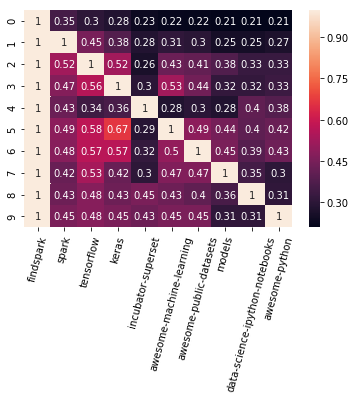

In [97]:
repoHeatMap(hottestRepos)